FRANK HERTZ EXPERIMENT

2.2. Temperature sweep with constant UH and U2 

Graph of different temperatures

In [51]:
from pathlib import Path
import re
import numpy as np
import pandas as pd

# Module calibration
# Data are already in physical units (U1 in V, IA in nA), so scales are 1.0
U1_SCALE = 1.0
I_SCALE_NA_PER_V = 1.0

# Display uncertainties in the physical columns from the sheet headers
# (columns are labeled U1[V] ±0.01 and IA[nA] ±0.01)
UNC_U1_OUT_V = 0.01   # ±0.01 V in U1 (already physical)
UNC_I_OUT_V  = 0.01   # ±0.01 nA in IA (already physical)

# Uncertainties propagated to physical units (identity scaling)
UNC_U1_REAL_V = U1_SCALE * UNC_U1_OUT_V   
UNC_I_NA      = I_SCALE_NA_PER_V * UNC_I_OUT_V  

# Path to the folder 
DATA_DIR = Path(r"C:\Users\Catalina Fuentes\OneDrive - Universidad de los andes\Escritorio\Materias\Materias 2025-2\Lab intermedio\2. Frank Hertz\Datos_FH\Actividad 2\2.2 Distintas temps")

# Target temperatures 
TEMPS = [170, 175, 180, 185]

def parse_temperature_from_name(name: str) -> int | None:
    """Extract T (°C) from names of the of the format ..._T180C_..."""
    m = re.search(r"_T(\d+)C", name)
    return int(m.group(1)) if m else None

def find_file_for_temp(temp: int) -> Path:
    """Find the file that contains _T{temp}C_ in its name, without assuming an extension."""
    matches = list(DATA_DIR.glob(f"*_T{temp}C_*"))
    if len(matches) != 1:
        raise FileNotFoundError(f"Esperado 1 archivo para T={temp}°C y se encontraron {len(matches)}.")
    return matches[0]

def read_two_columns(path: Path) -> pd.DataFrame:
    """
    Read the table with automatic separator; if it fails, use spaces/tabs.
    Convert decimal commas to periods if they appear.
    Return only the first two numeric columns as a DataFrame with columns ['U1_out', 'I_out'].
    NOTE: Here these columns are already in physical units (U1 in volts, IA in nA).
    """
    try:
        df = pd.read_csv(path, sep=None, engine="python")
    except Exception:
        df = pd.read_csv(path, delim_whitespace=True, engine="python")

    # Normalize decimal commas
    for c in df.columns:
        if df[c].dtype == object and df[c].astype(str).str.contains(",", na=False).any():
            df[c] = df[c].astype(str).str.replace(",", ".", regex=False)

    # Convert to numeric whenever possible
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Select first two numeric columns
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if len(num_cols) < 2:
        raise ValueError(f"No se hallaron dos columnas numéricas en {path.name}.")
    out = df[num_cols[:2]].copy()
    out.columns = ['U1_out', 'I_out']  # first: U1 [V], second: IA [nA] (already physical)
    return out




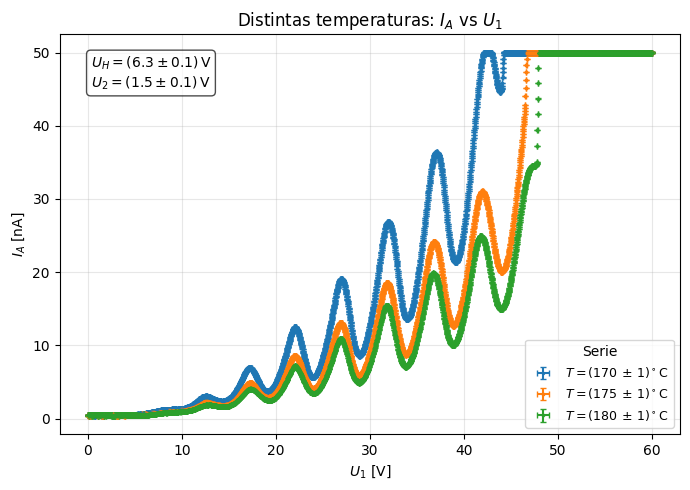

In [52]:
import matplotlib.pyplot as plt 
import numpy as np

# Load and plot the three files on a single figure (already in physical units)
plt.figure(figsize=(7, 5))
markers = ['o', 's', 'D']  # one marker per temperature

for i, T in enumerate(TEMPS):
    if T == 185:
        continue  # skip plotting 185 °C

    path = find_file_for_temp(T)
    df_out = read_two_columns(path)

    # No conversion needed: data are already in physical units
    U1_real = df_out['U1_out']            # [V]
    I_nA    = df_out['I_out']             # [nA]

    # Constant error bars from instrument resolution (already physical)
    xerr = np.full_like(U1_real, UNC_U1_REAL_V, dtype=float)
    yerr = np.full_like(I_nA,     UNC_I_NA,      dtype=float)

    # Drop NaNs before plotting
    mask = (~pd.isna(U1_real)) & (~pd.isna(I_nA))
    x = U1_real[mask].to_numpy()
    y = I_nA[mask].to_numpy()
    xerr = xerr[mask]
    yerr = yerr[mask]

    # Plot points with error bars (smaller markers to better see error bars)
    plt.errorbar(x, y, xerr=xerr, yerr=yerr,
             fmt=markers[i % len(markers)], linestyle='none',
             markersize=1.5, capsize=2,
             label=rf"$T = ({T}\,\pm\,1)^\circ$C")

# Labels and formatting
plt.xlabel(r"$U_1$ [V]")
plt.ylabel(r"$I_A$ [nA]")
plt.title("Distintas temperaturas: $I_A$ vs $U_1$")
plt.grid(True, which='both', alpha=0.3)
plt.legend(title="Serie", fontsize=9)

# Add text box with UH and U2 values
plt.text(0.05, 0.95,
         r"$U_H = (6.3 \pm 0.1)\,\mathrm{V}$" "\n"
         r"$U_2 = (1.5 \pm 0.1)\,\mathrm{V}$",
         transform=plt.gca().transAxes,
         fontsize=10, va="top", ha="left",
         bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

plt.tight_layout()
plt.savefig("FH_IA_vs_U1_Ts.png", dpi=200)
plt.show()





Find minima

In [ ]:
def _win_pts_for_volts(x, volts, min_pts=5):
    """Return an odd integer window size (in points) that spans ~`volts` around median Δx."""
    if len(x) < 2:
        return max(3, min_pts | 1)
    dx = np.median(np.diff(x))
    if not np.isfinite(dx) or dx <= 0:
        return max(3, min_pts | 1)
    n = int(max(min_pts, volts / dx))
    if n % 2 == 0:
        n += 1
    return max(3, n)

def minima_detrended_for_temp(
    temp: int,
    U1_MIN_V: float = 5.0,        # start looking early to catch the first minimum
    SMOOTH_WIN_PTS: int = 5,      # small rolling-median smoothing (odd)
    TREND_WIN_V: float = 3.0,     # wide window in Volts to estimate trend (rolling mean)
    MIN_PROM_RES_NA: float = 0.30,# min prominence in residual (nA)
    PROM_WIN_V: float = 0.8,      # neighborhood for prominence calc (±V)
    REFINE_V: float = 0.6,        # refine valley position within ±V on smoothed signal
    MIN_SEP_V: float = 1.8        # non-maximum suppression distance in Volts
) -> pd.DataFrame:
    """
    Detect minima of IA vs U1 by removing a local trend and finding valleys in the residual.
    Returns columns: n, DeltaU1_V, U1_min_V, IA_min_nA
    """
    path = find_file_for_temp(temp)
    df = read_two_columns(path).copy()

    # Clean and sort
    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['U1_out', 'I_out'])
    df = df.sort_values('U1_out').reset_index(drop=True)

    # Keep region of interest (start low to capture the first valley)
    df = df[df['U1_out'] >= U1_MIN_V].reset_index(drop=True)
    if df.empty:
        return pd.DataFrame(columns=['n', 'DeltaU1_V', 'U1_min_V', 'IA_min_nA'])

    x = df['U1_out'].to_numpy()
    y = df['I_out'].to_numpy()

    # Light smoothing (rolling median)
    if SMOOTH_WIN_PTS % 2 == 0:
        SMOOTH_WIN_PTS += 1
    y_med = pd.Series(y).rolling(window=SMOOTH_WIN_PTS, center=True, min_periods=1).median().to_numpy()

    # Local trend (rolling mean with window set in Volts)
    trend_win_pts = _win_pts_for_volts(x, TREND_WIN_V, min_pts=max(11, SMOOTH_WIN_PTS+2))
    y_trend = pd.Series(y_med).rolling(window=trend_win_pts, center=True, min_periods=1).mean().to_numpy()

    # Residual (oscillatory component)
    r = y_med - y_trend

    # First-pass candidates: slope change in residual (neg -> pos)
    dr = np.gradient(r, x, edge_order=2)
    cand_idx = [i for i in range(1, len(x)-1) if dr[i-1] < 0 and dr[i] > 0]

    # Prominence of residual within ±PROM_WIN_V
    def prom_residual(i):
        xl, xr = x[i] - PROM_WIN_V, x[i] + PROM_WIN_V
        m = (x >= xl) & (x <= xr)
        if not m.any():
            return 0.0
        rmax = np.max(r[m])
        return float(rmax - r[i])  # valleys: r[i] should be below local max

    cand_idx = [i for i in cand_idx if prom_residual(i) >= MIN_PROM_RES_NA]

    # Refine each candidate on the smoothed signal y_med (actual valley location)
    refined = []
    for i in cand_idx:
        xl, xr = x[i] - REFINE_V, x[i] + REFINE_V
        m = np.where((x >= xl) & (x <= xr))[0]
        if m.size == 0:
            continue
        j = m[np.argmin(y_med[m])]
        refined.append(j)

    # Non-maximum suppression in U1 (keep deepest within MIN_SEP_V)
    refined = sorted(set(refined), key=lambda k: x[k])
    selected = []
    for j in refined:
        if not selected:
            selected.append(j)
            continue
        last = selected[-1]
        if x[j] - x[last] < MIN_SEP_V:
            if y_med[j] < y_med[last]:
                selected[-1] = j
        else:
            selected.append(j)

    mins = pd.DataFrame({
        'U1_min_V': x[selected],
        'IA_min_nA': y_med[selected]
    }).sort_values('U1_min_V').reset_index(drop=True)

    # Build n and DeltaU1
    mins['n'] = np.arange(1, len(mins)+1)
    mins['DeltaU1_V'] = mins['U1_min_V'].diff()
    mins = mins[['n', 'DeltaU1_V', 'U1_min_V', 'IA_min_nA']]
    return mins

# ---- Run and print/save ----
results_by_T = {}
for T in TEMPS:
    try:
        tbl = minima_detrended_for_temp(
            T,
            U1_MIN_V=5.0,        # start early to include the first minimum
            SMOOTH_WIN_PTS=5,    # gentle smoothing
            TREND_WIN_V=3.0,     # trend window in Volts
            MIN_PROM_RES_NA=0.30,# lower threshold to catch the first valley
            PROM_WIN_V=0.8,
            REFINE_V=0.6,
            MIN_SEP_V=1.8
        )
        results_by_T[T] = tbl
        print(f"\n=== Detrended minima for T = ({T} ± 1) °C ===")
        print(tbl.to_string(index=False))
        tbl.to_csv(f"FH_minima_detrended_T{T}C.csv", index=False)
    except Exception as e:
        print(f"[WARN] T={T}: {e}")

# Optional: join all results in one CSV
if results_by_T:
    all_minima_df = pd.concat(
        [df.assign(T_C=T) for T, df in results_by_T.items()],
        ignore_index=True
    )
    all_minima_df = all_minima_df[['T_C', 'n', 'DeltaU1_V', 'U1_min_V', 'IA_min_nA']]
    all_minima_df.to_csv("FH_minima_detrended_all_T.csv", index=False)




=== Detrended minima for T = (170 ± 1) °C ===
 n  DeltaU1_V  U1_min_V  IA_min_nA
 1        NaN     10.30       1.39
 2       3.91     14.21       2.31
 3       4.86     19.07       3.69
 4       4.91     23.98       5.63
 5       4.90     28.88       8.61
 6       5.06     33.94      13.58
 7       5.15     39.09      21.39
 8       4.76     43.85      44.68

=== Detrended minima for T = (175 ± 1) °C ===
 n  DeltaU1_V  U1_min_V  IA_min_nA
 1        NaN     10.79       1.26
 2       3.66     14.45       1.84
 3       4.71     19.16       2.81
 4       4.72     23.88       4.06
 5       5.00     28.88       5.88
 6       4.91     33.79       8.74
 7       5.08     38.87      12.69
 8       5.13     44.00      20.05

=== Detrended minima for T = (180 ± 1) °C ===
 n  DeltaU1_V  U1_min_V  IA_min_nA
 1        NaN     14.79       1.75
 2       4.50     19.29       2.48
 3       4.81     24.10       3.49
 4       4.76     28.86       4.92
 5       4.96     33.82       7.09
 6       5.08     3